
<a id='arma'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Processos Estacionários de Covariância

## Conteúdo

- [Processos Estacionários de Covariância](#Processos-Estacionários-de-Covariância)  
  - [Resumo](#Resumo)  
  - [Introdução](#Introdução)  
  - [Análise Espectral](#Análise-Espectral)  
  - [Implementação](#Implementação)  

> *Devidamente traduzido, revisado e adaptado do [QuantEcon](https://quantecon.org/) pelos bolsistas CNPq, Pedro Luiz H. Furtado e Jonas Aragão M. Corpes, sob supervisão do Prof. Christiano Penna, do CAEN/UFC.*

## Resumo

Nessa aula vamos estudar processos estocásticos lineares estacionários de covariância, uma classe de modelos usados rotineiramente para estudar séries temporais econômico-financeiras.

Essa classe tem a vantagem de ser:

1. Simples o suficiente para ser descrito por uma teoria elegante e abrangente.
1. Relativamente ampla em termos dos tipos de dinâmica que pode representar.


Consideramos esses modelos em ambos domínios: do tempo e da frequência.

### Processos ARMA

Concentraremos muita atenção em modelos linear estacionários de covariância com um número finito de parâmetros.

Em particular, estudaremos processos estacionários do tipo ARMA, que formam uma pedra angular da teoria padrão da análise de séries temporais.

Todos os processos ARMA podem ser representados na forma [linear de espaço de estado](https://julia.quantecon.org/../tools_and_techniques/linear_models.html).

No entanto, o processo ARMA possui uma estrutura importante que torna importante estudá-los separadamente.

### Análise Espectral

A análise no domínio da frequência também é chamada de análise espectral.

Em essência, a análise espectral fornece uma representação alternativa da função de autocovariância de um processo estacionário de covariância.

Ter uma segunda representação deste importante objeto:

- Lança luz sobre a dinâmica do processo em questão.
- Permite uma representação mais simples e mais tratável em alguns casos importantes.

A famosa *transformação de Fourier* e sua inverso são usadas para mapear entre as duas representações.

### Leitura Adicional

Para leitura complementar, consulte:

- [[LS18]](https://julia.quantecon.org/../zreferences.html#ljungqvist2012), capítulo 2  
- [[Sar87]](https://julia.quantecon.org/../zreferences.html#sargent1987), capítulo 11  
- John Cochrane <a href=/_static/pdfs/time_series_book.pdf download>notas sobre a análise de séries temporais</a>, capítulo 8  
- [[Shi95]](https://julia.quantecon.org/../zreferences.html#shiryaev1995), capítulo 6  
- [[CC08]](https://julia.quantecon.org/../zreferences.html#cryerchan2008), todos

### Configuração

In [1]:
using InstantiateFromURL
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.5.0")
# github_project("QuantEcon/quantecon-notebooks-julia", version = "0.5.0", instantiate = true) # uncomment to force package installation

In [2]:
using LinearAlgebra, Statistics

## Introdução

Considere uma sequência de variáveis aleatórias $ \{ X_t \} $ indexadas por $ t \in \mathbb Z $ e tomando valores em $ \mathbb R $.

Então, $ \{ X_t \} $ começa no passado infinito e se extente para o futuro infinito — uma suposição conveniente e padrão.

Como em outros campos, a modelagem econômica bem-sucedida geralmente assume a existência de recursos que são constantes ao longo do tempo.

Se essas suposições estiverem corretas, cada nova observação $ X_t, X_{t+1},\ldots $ podemos fornecer informações adicionais sobre os recursos invariantes no tempo, permitindo que aprendamos à medida que os dados chegam.

Por esse motivo, focaremos no que se segue em processos estacionários - ou se tornarão após uma transformação (veja, por exemplo, [essa aula](https://julia.quantecon.org/additive_functionals.html) e [essa aula](https://julia.quantecon.org/multiplicative_functionals.html)).


<a id='arma-defs'></a>

### Definições


<a id='index-3'></a>
Um processo estocástico com valor real $ \{ X_t \} $ é chamado de *covariância estacionária* se:

1. Sua média $ \mu := \mathbb E X_t $ não depende de $ t $.  
1. Para todo $ k $ em $ \mathbb Z $, a $ k $-ésima autocovariância $ \gamma(k) := \mathbb E (X_t - \mu)(X_{t + k} - \mu) $ é finita e depende somente de $ k $.  


A função $ \gamma \colon \mathbb Z \to \mathbb R $ é chamada de *função de autocovariância* do processo.

Ao longo desta aula, trabalharemos exclusivamente com média zero (ou seja, $ \mu = 0 $) processo de estacionário de covariância.

A suposição de média zero em termos gerais não custa nada, de modo que trabalhar com processo com médias diferentes de zero  envolve nada mais do que adicionar uma constante.

### Exemplo 1: Ruído Branco

Talvez a classe mais simples de processos estacionários de covariância sejam os processos de ruído branco.

Um processo  $ \{ \epsilon_t \} $ é chamado de um *processo de ruído branco* se:

1. $ \mathbb E (\epsilon_t) = 0 $  
1. $ \gamma(k) = \sigma^2 \mathbf 1\{k = 0\} $ para qualquer $ \sigma > 0 $  


(Aqui $ \mathbf 1\{k = 0\} $ é definido como 1 se $ k = 0 $ e zero caso contrário)

Os processos de ruído branco atuam no papel de **blocos de construção** para processos com dinâmicas mais complicadas.


<a id='generalized-lps'></a>

### Exemplo 2: Processos Lineares Gerais

A partir do bloco de construção simples fornecido pelo ruído branco, podemos construir uma família muito flexível de processos estacionários de covariância - os *processos lineares gerais*.


<a id='equation-ma-inf'></a>
$$
X_t = \sum_{j=0}^{\infty} \psi_j \epsilon_{t-j},
\qquad t \in \mathbb Z \tag{1}
$$

onde

- $ \{\epsilon_t\} $ é um ruído branco.
- $ \{\psi_t\} $ é uma sequência quadrada e sumável em $ \mathbb R $ (que é, $ \sum_{t=0}^{\infty} \psi_t^2 < \infty $).


A sequência $ \{\psi_t\} $ é geralmente chamada de um *filtro linear*.

A equação [(1)](#equation-ma-inf) apresenta um processo de **média móvel** ou uma representção de média móvel. 

Com pouca manipulação é possível confirmar que a função de autocovariância para [(1)](#equation-ma-inf) é:


<a id='equation-ma-inf-ac'></a>
$$
\gamma(k) = \sigma^2 \sum_{j=0}^{\infty} \psi_j \psi_{j+k} \tag{2}
$$

A partir da [desigualdade de Cauchy-Schwartz](https://en.wikipedia.org/wiki/Cauchy%E2%80%93Schwarz_inequality) pode se mostrar que $ \gamma(k) $ satisfaz a equação [(2)](#equation-ma-inf-ac).

Evidentemente, $ \gamma(k) $ não depende do tempo $ t $.

### Decomposição de Wold

Notavelmente, a classe de processos lineares gerais ajuda bastante a descrever toda a classe de processos estacionários de covariância com média zero.

Em particular, [o teorema da decomposição de Wold](https://en.wikipedia.org/wiki/Wold%27s_theorem) afirma que todo processo estacionário de covariânca com média zero $ \{X_t\} $ pode ser escrito como:

$$
X_t = \sum_{j=0}^{\infty} \psi_j \epsilon_{t-j} + \eta_t
$$

onde

- $ \{\epsilon_t\} $ é um ruído branco.
- $ \{\psi_t\} $ é o quadrado sumável.
- $ \eta_t $ pode ser expresso como uma função linear de $ X_{t-1}, X_{t-2},\ldots $ e é perfeitamente previsível em horizontes arbitrariamente longos.

Para intuição e discussão adicional, consulte [[Sar87]](https://julia.quantecon.org/../zreferences.html#sargent1987), p. 286.

### AR e MA


<a id='index-8'></a>
Os processos lineares gerais são uma classe muito ampla de processos.

Vale a pena especializar-se àqueles para os quais existe uma representação com apenas muitos parâmetros finitos.

(A experiência e a teoria combinam-se para indicar que modelos com um número relativamente pequeno de parâmetros geralmente apresentam desempenho melhor que modelos maiores, especialmente para previsão)

Um exemplo muito simples desse modelo é o processo autorregressivo de primeira ordem ou AR (1):


<a id='equation-ar1-rep'></a>
$$
X_t = \phi X_{t-1} + \epsilon_t
\quad \text{onde} \quad
| \phi | < 1
\quad \text{e } \{ \epsilon_t \} \text{ é um ruído branco} \tag{3}
$$

Por substituição direta, é fácil verificar que $ X_t = \sum_{j=0}^{\infty} \phi^j \epsilon_{t-j} $.

Portanto $ \{X_t\} $ é um processo linear geral.

Aplicando [(2)](#equation-ma-inf-ac) à expressão anterior $ X_t $, obtemos a função de autocovariância AR(1):

<a id='equation-ar-acov'></a>
$$
\gamma(k) = \phi^k \frac{\sigma^2}{1 - \phi^2},
\qquad k = 0, 1, \ldots \tag{4}
$$

A figura a seguir mostra um exemplo dessa função para  $ \phi = 0.8 $ e $ \phi = -0.8 $ com $ \sigma = 1 $

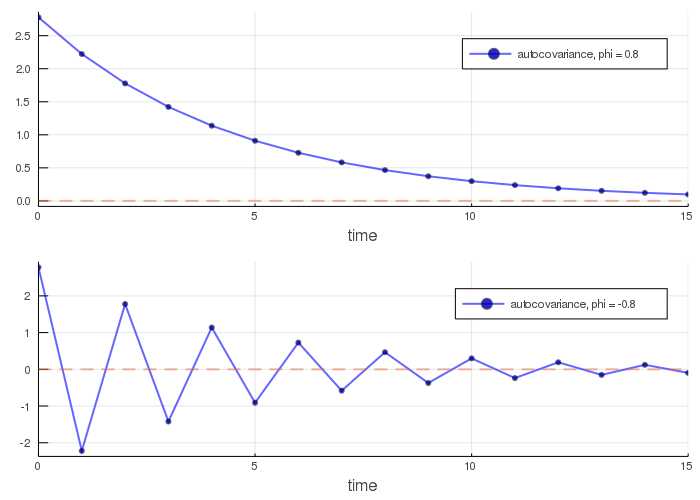

In [3]:
using Plots
gr(fmt=:png);

plt_1=plot()
plt_2=plot()
plots = [plt_1, plt_2]

for (i, ϕ) in enumerate((0.8, -0.8))
    times = 0:16
    acov = [ϕ.^k ./ (1 - ϕ.^2) for k in times]
    label = "autocovariance, phi = $ϕ"
    plot!(plots[i], times, acov, color=:blue, lw=2, marker=:circle, markersize=3,
          alpha=0.6, label=label)
    plot!(plots[i], legend=:topright, xlabel="time", xlim=(0,15))
    plot!(plots[i], seriestype=:hline, [0], linestyle=:dash, alpha=0.5, lw=2, label="")
end
plot(plots[1], plots[2], layout=(2,1), size=(700,500))

Outro processo muito simples é o processo MA(1) (aqui MA significa “média móvel”):

$$
X_t = \epsilon_t + \theta \epsilon_{t-1}
$$

Você será capaz de verificar que:

$$
\gamma(0) = \sigma^2 (1 + \theta^2),
\quad
\gamma(1) = \sigma^2 \theta,
\quad \text{e} \quad
\gamma(k) = 0 \quad \forall \, k > 1
$$

O processo AR(1) pode ser generalizado em um AR($ p $) e da mesma forma para MA(1).

Colocando tudo isso junto, obtemos o:

### Processos ARMA

Um processo estocástico $ \{X_t\} $ é chamado de *processo de média móvel autoregressiva*, ou ARMA($ p,q $), se puder ser escrito como:


<a id='equation-arma'></a>
$$
X_t = \phi_1 X_{t-1} + \cdots + \phi_p X_{t-p} +
    \epsilon_t + \theta_1 \epsilon_{t-1} + \cdots + \theta_q \epsilon_{t-q} \tag{5}
$$

onde $ \{ \epsilon_t \} $ é um ruído branco.

Uma notação alternativa para o processo ARMA usa o *operador defasagem* $ L $.

**Def.** Dada a variável arbitrária $ Y_t $, seja $ L^k Y_t := Y_{t-k} $.

Acontece que:

- operadores defasagem facilitam representações sucintas para processos estocásticos lineares. 
- manipulações algébricas que tratam o operador defasagem como um escalar comum são legítimas.


Usando $ L $, podemos reescrever [(5)](#equation-arma) como:


<a id='equation-arma-lag'></a>
$$
L^0 X_t - \phi_1 L^1 X_t - \cdots - \phi_p L^p X_t = L^0 \epsilon_t + \theta_1 L^1 \epsilon_t + \cdots + \theta_q L^q \epsilon_t \tag{6}
$$

Sejam $ \phi(z) $ e $ \theta(z) $ polinômios


<a id='equation-arma-poly'></a>
$$
\phi(z) := 1 - \phi_1 z - \cdots - \phi_p z^p
\quad \text{e} \quad
\theta(z) := 1 + \theta_1 z + \cdots + \theta_q z^q \tag{7}
$$

então [(6)](#equation-arma-lag) se torna:


<a id='equation-arma-lag1'></a>
$$
\phi(L) X_t = \theta(L) \epsilon_t \tag{8}
$$

A seguir, **sempre assumimos** que as raizes dos polinômios $ \phi(z) $ fique fora do círculo unitário no plano complexo..

Esta condição é suficiente para garantir que o processo ARMA($ p,q $) é convariânte estacionário.

De fato, isso implica que o processo se enquadra na classe de processos lineares gerais [descritas acima](#generalized-lps).

Que é, dado um processo ARMA ($ p,q $) $ \{ X_t \} $ satisfazendo a condição do círculo unitário, existe uma sequência quadrada sumável $ \{\psi_t\} $ com $ X_t = \sum_{j=0}^{\infty} \psi_j \epsilon_{t-j} $ para todo $ t $.

A sequência $ \{\psi_t\} $ pode ser obtido por um procedimento recursivo descrito na página 79 de [[CC08]](https://julia.quantecon.org/../zreferences.html#cryerchan2008).

A função $ t \mapsto \psi_t $ é geralmente chamada de *função de impulso resposta*.

## Análise Espectral

As funções de autocovariância fornecem uma grande quantidade de informações sobre processos estacionários de covariância.

De fato, para processos gaussianos com média zero, a função de autocovariância caracteriza toda a distribuição conjunta.

Mesmo para processos não gaussianos, ele fornece uma quantidade significativa de informações.

Acontece que existe uma representação alternativa da função de autocovariância de um processo estacionário de covariância, chamado *densidade espectral*.

Às vezes, a densidade espectral é mais fácil de derivar, mais fácil de manipular e fornece intuição adicional.

### Números Complexos

Antes de discutir a densidade espectral, convidamos você a recordar as principais propriedades de números complexos (ou [pular para a próxima seção](#arma-specd)).

Pode ser útil lembrar que, em um sentido formal, números complexos são apenas pontos $ (x, y) \in \mathbb R^2 $ dotados de uma noção específica de multiplicação.

Quando $ (x, y) $ é considerado como um número complexo, $ x $ é chamado de *parte real* e $ y $ é chamada de *parte imaginárias*.

O *módulo* ou *o valor absoluto* de um número complexo $ z = (x, y) $ é apenas sua norma Euclidiana no $ \mathbb R^2 $, mas são usualmente escritas como $ |z| $ em vez de $ \|z\| $.

O produto de dois números complexos $ (x, y) $ e $ (u, v) $ é definido como $ (xu - vy, xv + yu) $, enquanto a adição é uma adição padrão de vetores pontuais.

Quando dotado dessas noções de multiplicação e adição, o conjunto de números complexos forma um [campo](https://en.wikipedia.org/wiki/Field_%28mathematics%29) —  adição e a multiplicação funcionam bem juntas, assim como em $ \mathbb R $.

O número complexo $ (x, y) $ é geralmente escrito como $ x + i y $, onde $ i $ é chamado de *unidade imaginária*, e é entendido a obedecer $ i^2 = -1 $.

A notação $ x + i y $ fornece uma maneira fácil de lembrar a definição de multiplicação dada acima, porque, procedendo ingenuamente,

$$
(x + i y) (u + i v) = xu - yv + i (xv + yu)
$$

Convertido de volta à nossa primeira notação, isso se torna $ (xu - vy, xv + yu) $ como prometido.

Números complexos podem ser representados na forma polar $ r e^{i \omega} $ onde:

$$
r e^{i \omega} := r (\cos(\omega) + i \sin(\omega)) = x + i y
$$

onde $ x = r \cos(\omega), y = r \sin(\omega) $, e $ \omega = \arctan(y/z) $ ou $ \tan(\omega) = y/x $.


<a id='arma-specd'></a>

### Spectral Densities

Seja $ \{ X_t \} $ um processo estacionário de covariância com função de autocovariância $ \gamma $ satisfazendo $ \sum_{k} \gamma(k)^2 < \infty $.

A *densidade espectral* $ f $ de $ \{ X_t \} $ é definida como a [transformação de Fourier de tempo discreto](https://en.wikipedia.org/wiki/Discrete-time_Fourier_transform) de sua função de autocovariância $ \gamma $

$$
f(\omega) := \sum_{k \in \mathbb Z} \gamma(k) e^{-i \omega k},
\qquad \omega \in \mathbb R
$$

(Alguns autores normalizam a expressão à direita por constantes como $ 1/\pi $ — a convenção escolhida faz pouca diferença, desde que você seja consistente)

Usando o fato de que $ \gamma $ é *uniforme*, no sentido de que $ \gamma(t) = \gamma(-t) $ para todo $ t $, podemos mostrar que:


<a id='equation-arma-sd-cos'></a>
$$
f(\omega) = \gamma(0) + 2 \sum_{k \geq 1} \gamma(k) \cos(\omega k) \tag{9}
$$

Não é dificl de confirmar que $ f $ é:

- com valor real  
- uniforme ($ f(\omega) = f(-\omega) $   ),  e 
- $ 2\pi $-periódico, no sentido de $ f(2\pi + \omega) = f(\omega) $ para todo $ \omega $  


Segue-se que os valores de $ f $ em $ [0, \pi] $ determinam os valores de $ f $ em todos os $ \mathbb R $ — a prova é um exercício.

Por esse motivo, é padrão plotar a densidade espectral apenas no intervalo  $ [0, \pi] $.


<a id='arma-wnsd'></a>

### Exemplo 1: Ruído Branco

Considere um processo ruído branco $ \{\epsilon_t\} $ com desvio padrão $ \sigma $.

É fácil verificar que nesse caso $ f(\omega) = \sigma^2 $. Então $ f $ é uma função constante.

Como veremos, isso pode ser interpretado como significando que "todas as frequências estão igualmente presentes".

(A luz branca possui essa propriedade quando a frequência se refere ao espectro visível, uma conexão que fornece as origens do termo "ruído branco")

### Exemplo 2: AR e MA e ARMA


<a id='ar1-acov'></a>
É um exercício mostrar que o processo MA(1)  $ X_t = \theta \epsilon_{t-1} + \epsilon_t $ tem densidade espectral:


<a id='equation-ma1-sd-ed'></a>
$$
f(\omega)
= \sigma^2 ( 1 + 2 \theta \cos(\omega) + \theta^2 ) \tag{10}
$$

Com um pouco mais de esforço, é possível mostrar (veja, por exemplo, p. 261 de [[Sar87]](https://julia.quantecon.org/../zreferences.html#sargent1987)) que a densidade espectral de um processo AR(1) $ X_t = \phi X_{t-1} + \epsilon_t $ é:


<a id='equation-ar1-sd-ed'></a>
$$
f(\omega)
= \frac{\sigma^2}{ 1 - 2 \phi \cos(\omega) + \phi^2 } \tag{11}
$$

De um modo mais geral, pode ser demonstrado que a densidade espectral do processo ARMA [(5)](#equation-arma) é:


<a id='arma-spec-den'></a>

<a id='equation-arma-sd'></a>
$$
f(\omega) = \left| \frac{\theta(e^{i\omega})}{\phi(e^{i\omega})} \right|^2 \sigma^2 \tag{12}
$$

onde

- $ \sigma $ é o desvio padrão do processo ruído branco $ \{\epsilon_t\} $.  
- os polinômios $ \phi(\cdot) $ e $ \theta(\cdot) $ são definidos em [(7)](#equation-arma-poly).  


A derivação de [(12)](#equation-arma-sd) usa o fato de que as convoluções se tornam produtos sob transformações de Fourier.

A prova é elegante e pode ser encontrada em muitos lugares - veja, por exemplo,[[Sar87]](https://julia.quantecon.org/../zreferences.html#sargent1987), capítulo 11, seção 4.

É um ótimo exercício verificar se [(10)](#equation-ma1-sd-ed) e [(11)](#equation-ar1-sd-ed) são realmente casos especiais de[(12)](#equation-arma-sd).

### Interpretando a Densidade Espectral


<a id='index-18'></a>
A plotagem [(11)](#equation-ar1-sd-ed) revela a forma da densidade espectral para o modelo AR (1) quando  $ \phi $ assume valores 0.8 e -0.8 respectivamente.

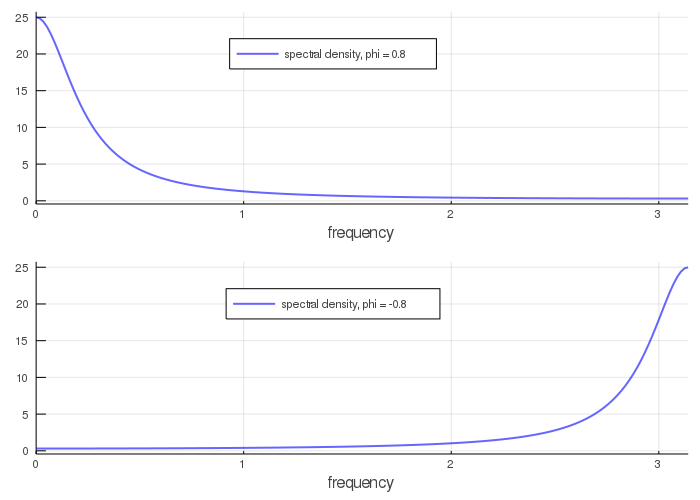

In [4]:
ar1_sd(ϕ, ω) = 1 ./ (1 .- 2 * ϕ * cos.(ω) .+ ϕ.^2)

ω_s = range(0, π, length = 180)

plt_1=plot()
plt_2=plot()
plots=[plt_1, plt_2]

for (i, ϕ) in enumerate((0.8, -0.8))
    sd = ar1_sd(ϕ, ω_s)
    label = "spectral density, phi = $ϕ"
    plot!(plots[i], ω_s, sd, color=:blue, alpha=0.6, lw=2, label=label)
    plot!(plots[i], legend=:top, xlabel="frequency", xlim=(0,π))
end
plot(plots[1], plots[2], layout=(2,1), size=(700,500))

Essas densidades espectrais correspondem às funções de autocovariância para o processo AR (1) [mostradas acima](#ar1-acov).

Informalmente, pensamos na densidade espectral como sendo grande em $ \omega \in [0, \pi] $ em que a função de autocovariância parece exibir aproximadamente grandes ciclos amortecidos.

Para ver a idéia, vamos considerar por que, no painel inferior da figura anterior, a densidade espectral do caso  $ \phi = -0.8 $ é grande em $ \omega = \pi $.

Lembre-se de que a densidade espectral pode ser expressa como:


<a id='equation-sumpr'></a>
$$
f(\omega)
= \gamma(0) + 2 \sum_{k \geq 1} \gamma(k) \cos(\omega k)
= \gamma(0) + 2 \sum_{k \geq 1} (-0.8)^k \cos(\omega k) \tag{13}
$$

Quando avaliamos isso em $ \omega = \pi $, obtemos um grande número porque
$ \cos(\pi k) $ é grande e positivo quando $ (-0.8)^k $ é positivo, e grande em valor absoluto e negativo quando $ (-0.8)^k $ é negativo.

Portanto o produto é sempre grande e positivo, e portanto a soma dos produtos do lado direito de [(13)](#equation-sumpr) é grande.

Essas ideias são ilustradas na próxima figura, que possui $ k $ no eixo horizontal.

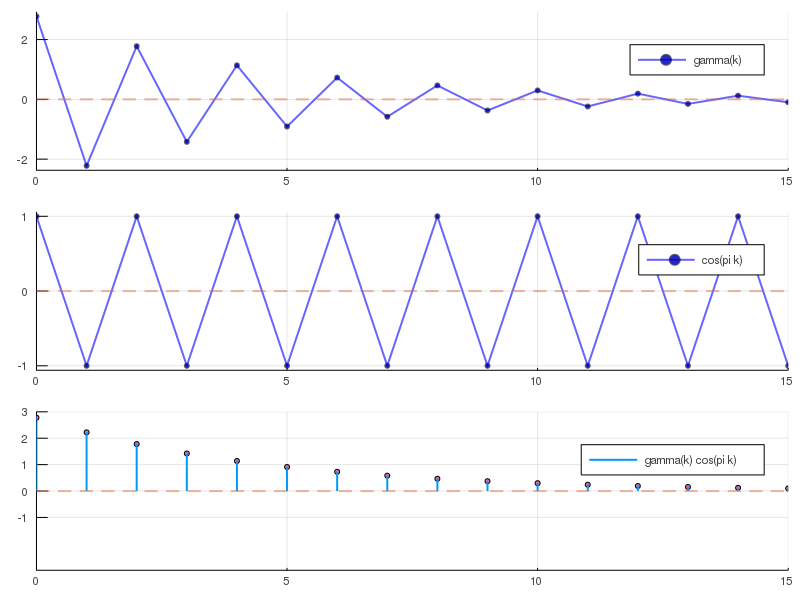

In [5]:
ϕ = -0.8
times = 0:16
y1 = [ϕ.^k ./ (1 - ϕ.^2) for k in times]
y2 = [cos.(π * k) for k in times]
y3 = [a * b for (a, b) in zip(y1, y2)]

# Autocovariância qunado ϕ = -0.8
plt_1 = plot(times, y1, color=:blue, lw=2, marker=:circle, markersize=3,
             alpha=0.6, label="gamma(k)")
plot!(plt_1, seriestype=:hline, [0], linestyle=:dash, alpha=0.5,
      lw=2, label="")
plot!(plt_1, legend=:topright, xlim=(0,15), yticks=[-2, 0, 2])

# ciclos a frequência π
plt_2 = plot(times, y2, color=:blue, lw=2, marker=:circle, markersize=3,
             alpha=0.6, label="cos(pi k)")
plot!(plt_2, seriestype=:hline, [0], linestyle=:dash, alpha=0.5,
      lw=2, label="")
plot!(plt_2, legend=:topright, xlim=(0,15), yticks=[-1, 0, 1])

# Produto
plt_3 = plot(times, y3, seriestype=:sticks, marker=:circle, markersize=3,
             lw=2, label="gamma(k) cos(pi k)")
plot!(plt_3, seriestype=:hline, [0], linestyle=:dash, alpha=0.5,
      lw=2, label="")
plot!(plt_3, legend=:topright, xlim=(0,15), ylim=(-3,3), yticks=[-1, 0, 1, 2, 3])

plot(plt_1, plt_2, plt_3, layout=(3,1), size=(800,600))

Por outro lado, se avaliarmos $ f(\omega) $ em $ \omega = \pi / 3 $, então os ciclos não são correspondentes, a sequência  $ \gamma(k) \cos(\omega k) $ contém
ambos termos positivos e negativos, e portanto a soma desses termos são muito menores.

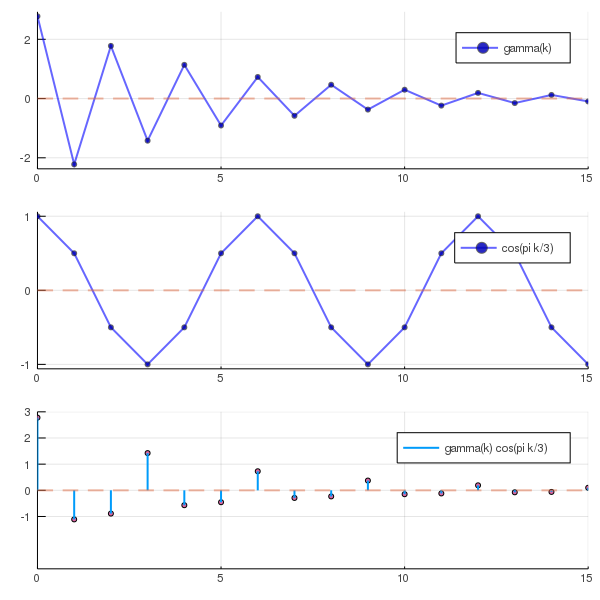

In [6]:
ϕ = -0.8
times = 0:16
y1 = [ϕ.^k ./ (1 - ϕ.^2) for k in times]
y2 = [cos.(π * k/3) for k in times]
y3 = [a * b for (a, b) in zip(y1, y2)]

# Autocovariância quando ϕ = -0.8
plt_1 = plot(times, y1, color=:blue, lw=2, marker=:circle, markersize=3,
             alpha=0.6, label="gamma(k)")
plot!(plt_1, seriestype=:hline, [0], linestyle=:dash, alpha=0.5,
      lw=2, label="")
plot!(plt_1, legend=:topright, xlim=(0,15), yticks=[-2, 0, 2])

# ciclos a frequência π
plt_2 = plot(times, y2, color=:blue, lw=2, marker=:circle, markersize=3,
             alpha=0.6, label="cos(pi k/3)")
plot!(plt_2, seriestype=:hline, [0], linestyle=:dash, alpha=0.5,
      lw=2, label="")
plot!(plt_2, legend=:topright, xlim=(0,15), yticks=[-1, 0, 1])

# produto
plt_3 = plot(times, y3, seriestype=:sticks, marker=:circle, markersize=3,
             lw=2, label="gamma(k) cos(pi k/3)")
plot!(plt_3, seriestype=:hline, [0], linestyle=:dash, alpha=0.5,
      lw=2, label="")
plot!(plt_3, legend=:topright, xlim=(0,15), ylim=(-3,3), yticks=[-1, 0, 1, 2, 3])

plot(plt_1, plt_2, plt_3, layout=(3,1), size=(600,600))

Em resumo, a densidade espectral é grande nas frequências $ \omega $ onde a função de autocovariânicas exibes ciclos amortecidos.

### Invertendo a Transformação


<a id='index-19'></a>
Acabamos de ver que a densidade espectral é usual no sentido de fornecer uma frequência-baseada na perspectiva da estrutura da autocovariância de um processo estacionário de covariância.

Outra razão da densidade espectral ser útil é que a mesma pode ser “invertida” para recuperar a função de autocovariância via a *transformação inversa de Fourier*.

Em particular, para todo $ k \in \mathbb Z $, temos:


<a id='equation-ift'></a>
$$
\gamma(k) = \frac{1}{2 \pi} \int_{-\pi}^{\pi} f(\omega) e^{i \omega k} d\omega \tag{14}
$$

Isso é conveniente em situações onde a densidade espectral é mais fácil de calcular e manipular que a função de autocovariância.

(Por exemplo, a expressão [(12)](#equation-arma-sd) para a densidade espectral ARMA é mais fácil de trabalhar do que a expressão para a autocovariância ARMA)

### Teoria Matemática


<a id='index-20'></a>
Essa seção é baseada em [[Sar87]](https://julia.quantecon.org/../zreferences.html#sargent1987), p. 249-253, e foi incluida para aqueles que:

- gostariam de um pouco mais de uma visão das densidades espectrais.
- e ter ao menos alguma base na teoria [do espaço de Hilbert](https://en.wikipedia.org/wiki/Hilbert_space).


Os outros sintam-se livres para avançar para a [próxima seção](#arma-imp) — nada desse material é necessário para progredir na computação.

Lembre-se de que todo espaço [separável](https://en.wikipedia.org/wiki/Separable_space) de Hilbert $ H $ possui uma base ortonormal contável $ \{ h_k \} $.

O legal em tal base é que cada $ f \in H $ satisfaz:


<a id='equation-arma-fc'></a>
$$
f = \sum_k \alpha_k h_k
\quad \text{onde} \quad
\alpha_k := \langle f, h_k \rangle \tag{15}
$$

onde $ \langle \cdot, \cdot \rangle $ denota o produto interno em $ H $.

Assim, $ f $ pode ser representado com qualquer grau de precisão combinando linearmente vetores de base.

A sequência escalar $ \alpha = \{\alpha_k\} $ é chamada de *coeficiêntes de Fourier* de $ f $, e satisfaz $ \sum_k |\alpha_k|^2 < \infty $.

Em outras palavras, $ \alpha $ está em $ \ell_2 $, o conjunto de sequências quadradas somadas.

Considere um operador $ T $ que mapeia $ \alpha \in \ell_2 $ em sua expansão $ \sum_k \alpha_k h_k \in H $.

Os coeficiêntes de Fourier de $ T\alpha $ são apenas $ \alpha = \{ \alpha_k \} $, como você pode verificar, confirmando que $ \langle T \alpha, h_k \rangle = \alpha_k $.

Usando resultados elementares da teoria do espaço de Hilbert, pode-se mostrar que:

- $ T $ é um para um - se  $ \alpha $ e $ \beta $ são distintos em $ \ell_2 $, também são suas expansões em  $ H $.  
- $ T $ está em - se $ f \in H $ então sua pré-imagem em $ \ell_2 $ é a sequência $ \alpha $ dada por $ \alpha_k = \langle f, h_k \rangle $.
- $ T $ é uma isometría linear - em particular  $ \langle \alpha, \beta \rangle = \langle T\alpha, T\beta \rangle $.  


Resumindo esses resultados, dizemos que qualquer espaço separável Hilbert é isometricamente isomórfico para $ \ell_2 $.

Em essência, este diz que cada espaço separável de Hilbert consideramos que é apenas uma maneira diferente de olhar para o espaço fundamentais ℓ $ \ell_2 $.

Com isso em mente, vamos nos especializar em um cenário em que:

- $ \gamma \in \ell_2 $ é a função de autocovariância de um processo estacionário de covariância $ f $ é a densidade espectral
- $ H = L_2 $, onde $ L_2 $ é o conjunto de funções quadradas somadas no intervalo $ [-\pi, \pi] $, com produto interno $ \langle g, h \rangle = \int_{-\pi}^{\pi} g(\omega) h(\omega) d \omega $  
- $ \{h_k\} = $ a base ortonormal para $ L_2 $ dado pelo conjunto de funções trigonométricas.


$$
h_k(\omega) = \frac{e^{i \omega k}}{\sqrt{2 \pi}},
\quad k \in \mathbb Z,
\quad \omega \in [-\pi, \pi]
$$

Usando a definição de $ T $ acima e o fato de que $ f $ é par, agora temos:


<a id='equation-arma-it'></a>
$$
T \gamma
= \sum_{k \in \mathbb Z}
\gamma(k) \frac{e^{i \omega k}}{\sqrt{2 \pi}} = \frac{1}{\sqrt{2 \pi}} f(\omega) \tag{16}
$$

Em outras palavras, além de um múltiplo escalar, a densidade espectral é apenas uma transformação de  $ \gamma \in \ell_2 $ sob uma certa isometria linear - uma maneira diferente de visualizar $ \gamma $.

Em particular, é uma expansão da função de autocovariância em relação às funções da base trigonométrica em  $ L_2 $.

Como discutido acima, os coeficientes de Fourier de $ T \gamma $ são dados pela sequência $ \gamma $, e,
em particular, $ \gamma(k) = \langle T \gamma, h_k \rangle $.

Transformar esse produto interno em sua expressão integral e usar [(16)](#equation-arma-it) temos
[(14)](#equation-ift), justificando nossa expressão anterior para a transformação inversa.


<a id='arma-imp'></a>

## Implementação

A maioria do código para trabalhar com modelos estacionários de covariânica lidam com modelos ARMA.

O código do Julia para estudar modelos ARMA pode ser encontrado no pacote `DSP.jl`.

Como esse código não cobre completamente nossas necessidades — particularmente em relação à análise espectra — montamos o módulo [arma.jl](https://github.com/QuantEcon/QuantEcon.jl/blob/master/src/arma.jl), que é parte do pacote [QuantEcon.jl](http://quantecon.org/quantecon-jl).

O módulo fornece funçõess para mapear modelos ARMA($ p,q $) dentro da suas:

1. funções de impulso resposta.
1. séries temporais simuladas.
1. funções de autocovariância. 
1. densidade espectral.

### Aplicação

Vamos usar esse código para replicar os gráficos nas páginas 68–69 de [[LS18]](https://julia.quantecon.org/../zreferences.html#ljungqvist2012).

Aqui está algumas funções para gerar os gráficos.

In [7]:
using QuantEcon, Random

# plot functions
function plot_spectral_density(arma, plt)
    (w, spect) = spectral_density(arma, two_pi=false)
    plot!(plt, w, spect, lw=2, alpha=0.7,label="")
    plot!(plt, title="Spectral density", xlim=(0,π),
          xlabel="frequency", ylabel="spectrum", yscale=:log)
    return plt
end

function plot_spectral_density(arma)
    plt = plot()
    plot_spectral_density(arma, plt=plt)
    return plt
end

function plot_autocovariance(arma, plt)
    acov = autocovariance(arma)
    n = length(acov)
    plot!(plt, 0:(n-1), acov, seriestype=:sticks, marker=:circle,
          markersize=2,label="")
    plot!(plt, seriestype=:hline, [0], color=:red, label="")
    plot!(plt, title="Autocovariance", xlim=(-0.5, n-0.5),
          xlabel="time", ylabel="autocovariance")
    return plt
end

function plot_autocovariance(arma)
    plt = plot()
    plot_spectral_density(arma, plt=plt)
    return plt
end

function plot_impulse_response(arma, plt)
    psi = impulse_response(arma)
    n = length(psi)
    plot!(plt, 0:(n-1), psi, seriestype=:sticks, marker=:circle,
          markersize=2, label="")
    plot!(plt, seriestype=:hline, [0], color=:red, label="")
    plot!(plt, title="Impluse response", xlim=(-0.5,n-0.5),
          xlabel="time", ylabel="response")
    return plt
end

function plot_impulse_response(arma)
    plt = plot()
    plot_spectral_density(arma, plt=plt)
    return plt
end

function plot_simulation(arma, plt)
    X = simulation(arma)
    n = length(X)
    plot!(plt, 0:(n-1), X, lw=2, alpha=0.7, label="")
    plot!(plt, title="Sample path", xlim=(0,0,n), xlabel="time", ylabel="state space")
    return plt
end

function plot_simulation(arma)
    plt = plot()
    plot_spectral_density(arma, plt=plt)
    return plt
end

function quad_plot(arma)
    plt_1 = plot()
    plt_2 = plot()
    plt_3 = plot()
    plt_4 = plot()
    plots = [plt_1, plt_2, plt_3, plt_4]

    plot_functions = [plot_spectral_density,
                      plot_impulse_response,
                      plot_autocovariance,
                      plot_simulation]
    for (i, plt, plot_func) in zip(1:1:4, plots, plot_functions)
        plots[i] = plot_func(arma, plt)
    end
    return plot(plots[1], plots[2], plots[3], plots[4], layout=(2,2), size=(800,800))

end

quad_plot (generic function with 1 method)

Agora vamos chamar essas funções para gerar os gráficos.

Usaremos o modelo $ X_t = 0.5 X_{t-1} + \epsilon_t - 0.8 \epsilon_{t-2} $

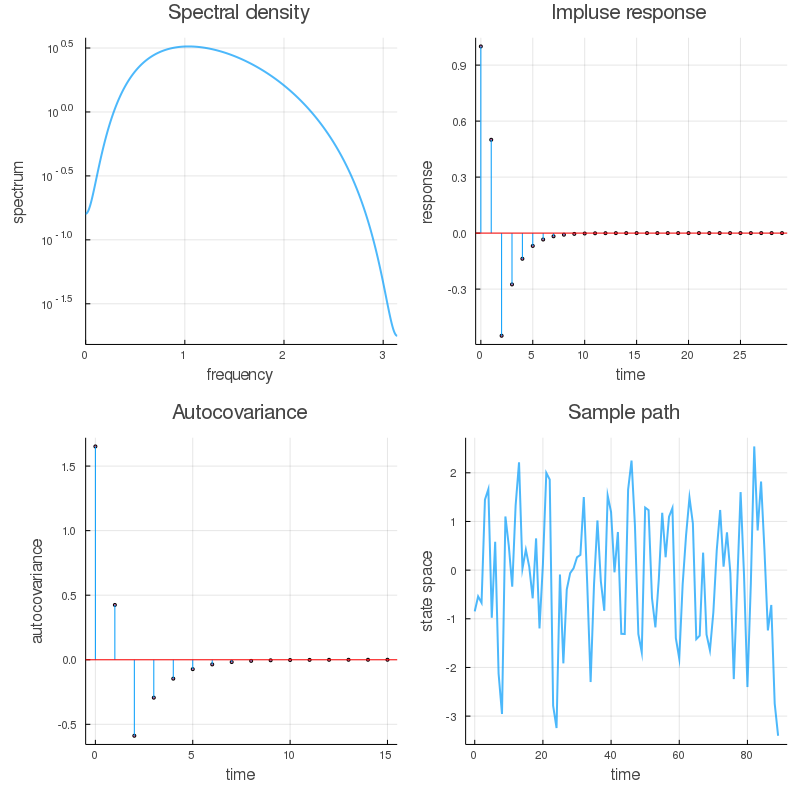

In [8]:
Random.seed!(42) # Para resultados reprodutíveis.
ϕ = 0.5;
θ = [0, -0.8];
arma = ARMA(ϕ, θ, 1.0)
quad_plot(arma)

### Explicação

A chamada.

```julia
arma = ARMA(ϕ, θ, σ)
```


cria uma instância `arma` que representa o modelo ARMA($ p, q $):

$$
X_t = \phi_1 X_{t-1} + ... + \phi_p X_{t-p} +
    \epsilon_t + \theta_1 \epsilon_{t-1} + ... + \theta_q \epsilon_{t-q}
$$

Se `ϕ` e `θ` são matrizes ou sequências, então a interpretação será:

- `ϕ` mantém o vetor de parâmetros  $ (\phi_1, \phi_2,..., \phi_p) $  
- `θ` mantém o vetor de parâmetros  $ (\theta_1, \theta_2,..., \theta_q) $  


O parâmetro `σ` é sempre um escalar, o desvio padrão do ruído branco.

Também permitimos `ϕ` e `θ` ser escalares, nesse caso, o modelo será interpretado como:

$$
X_t = \phi X_{t-1} + \epsilon_t + \theta \epsilon_{t-1}
$$

Os dois pacotes numéricos mais úteis para trabalhar com modelos ARMA e rotina no Julia são `DSP.jl` e o `fft`.

### Computando a Função de Autocovariância

Como discutido acima, para processos ARMA, a densidade espectral tem uma [simples representação](#arma-spec-den) que é relativamente fácil de calcular.

Dado esse fato, a maneira mais fácil de se obter a função de autocovariância é recuperá-la da densidade espectral via transformação de Fourier inversa.

Aqui usamos a rotina de transformação de Fourier de Julia, que envolve um pacote padrão baseado em C chamado FFTW.

Uma olhada na  [documentação fft](https://docs.julialang.org/en/stable/stdlib/math/#Base.DFT.fft) mostra que o ifft de transformação inversa leva uma determinada sequência $ A_0, A_1, \ldots, A_{n-1} $ e retorna a sequência $ a_0, a_1, \ldots, a_{n-1} $ definida por:

$$
a_k = \frac{1}{n} \sum_{t=0}^{n-1} A_t e^{ik 2\pi t / n}
$$

Então, se definirmos $ A_t = f(\omega_t) $, onde $ f $ é a densidade espectral e
$ \omega_t := 2 \pi t / n $, então:

$$
a_k
= \frac{1}{n} \sum_{t=0}^{n-1} f(\omega_t) e^{i \omega_t k}
= \frac{1}{2\pi} \frac{2 \pi}{n} \sum_{t=0}^{n-1} f(\omega_t) e^{i \omega_t k},
\qquad
\omega_t := 2 \pi t / n
$$

Para $ n $ suficientemente grande, então nos temos:

$$
a_k
\approx \frac{1}{2\pi} \int_0^{2 \pi} f(\omega) e^{i \omega k} d \omega
= \frac{1}{2\pi} \int_{-\pi}^{\pi} f(\omega) e^{i \omega k} d \omega
$$

(Você pode verificar a última igualdade)

Em vista de [(14)](#equation-ift) agora temos mostrado que, para um $ n $ suficientemente grande, $ a_k \approx \gamma(k) $ — que é exatamente o que queremos calcular.